# Practicum 2: Analyze Power Flow with Realistic Time Series Load Data

objectives:
- Learn how to perform batch calculations with PowerGridModel
- Analyze the different system states at different times of the week.

In [1]:
import json
from pprint import pprint

import numpy as np
import networkx as nx
import power_grid_model as pgm
import pandas as pd
from power_grid_model import initialize_array, PowerGridModel, ComponentType, ComponentAttributeFilterOptions, DatasetType, CalculationType
from power_grid_model.utils import json_serialize, json_deserialize
from power_grid_model.validation import assert_valid_input_data, assert_valid_batch_data

import matplotlib.pyplot as plt
import math
from matplotlib.gridspec import GridSpec

from plot_utils.plot import plot_power_grid_v1, plot_power_grid

## Load Grid Parameters and Time Series Data


In [2]:
# load grid data
with open("data/arena_raw_data_65.json") as fp:
    data = fp.read()
pprint(json.loads(data))
dataset = json_deserialize(data)

{'attributes': {},
 'data': {'line': [{'c1': 0,
                    'from_node': 0,
                    'from_status': 1,
                    'i_n': 355,
                    'id': 40,
                    'r1': 0.02188768893386404,
                    'tan1': 0,
                    'to_node': 1,
                    'to_status': 1,
                    'x1': 0.00881127343284934},
                   {'c1': 0,
                    'from_node': 0,
                    'from_status': 1,
                    'i_n': 295,
                    'id': 41,
                    'r1': 0.0016434820870070421,
                    'tan1': 0,
                    'to_node': 2,
                    'to_status': 1,
                    'x1': 0.0006158253421727322},
                   {'c1': 0,
                    'from_node': 0,
                    'from_status': 1,
                    'i_n': 355,
                    'id': 42,
                    'r1': 0.015710611988650345,
                    'tan1': 0,
           

In [3]:
# load time series data from csv
df_load_profile = pd.read_csv("data/processed/transformer_data_week.csv")
load_profile = df_load_profile[df_load_profile.columns[1:]].to_numpy()  # (672, 39)

# convert to PowerGridModel data format
load_profile_array = initialize_array(
    DatasetType.update,
    ComponentType.sym_load,
    load_profile.shape,  # (672, 39)
)
load_profile_array["id"] = [dataset["sym_load"]["id"]]
load_profile_array["p_specified"] = load_profile * 1e3
load_profile_array["q_specified"] = load_profile * 1e3 * 0.4843  # PF = 0.9

time_series_mutation = {
    ComponentType.sym_load: load_profile_array,
}
assert_valid_batch_data(input_data=dataset, update_data=time_series_mutation,
                        calculation_type=CalculationType.power_flow)

## Calculate Power Flow

In [4]:
# build PowerGridModel with batched data and calculate power flow
model = PowerGridModel(dataset)
output_data = model.calculate_power_flow(
    update_data=time_series_mutation,
)

## Plot the Results

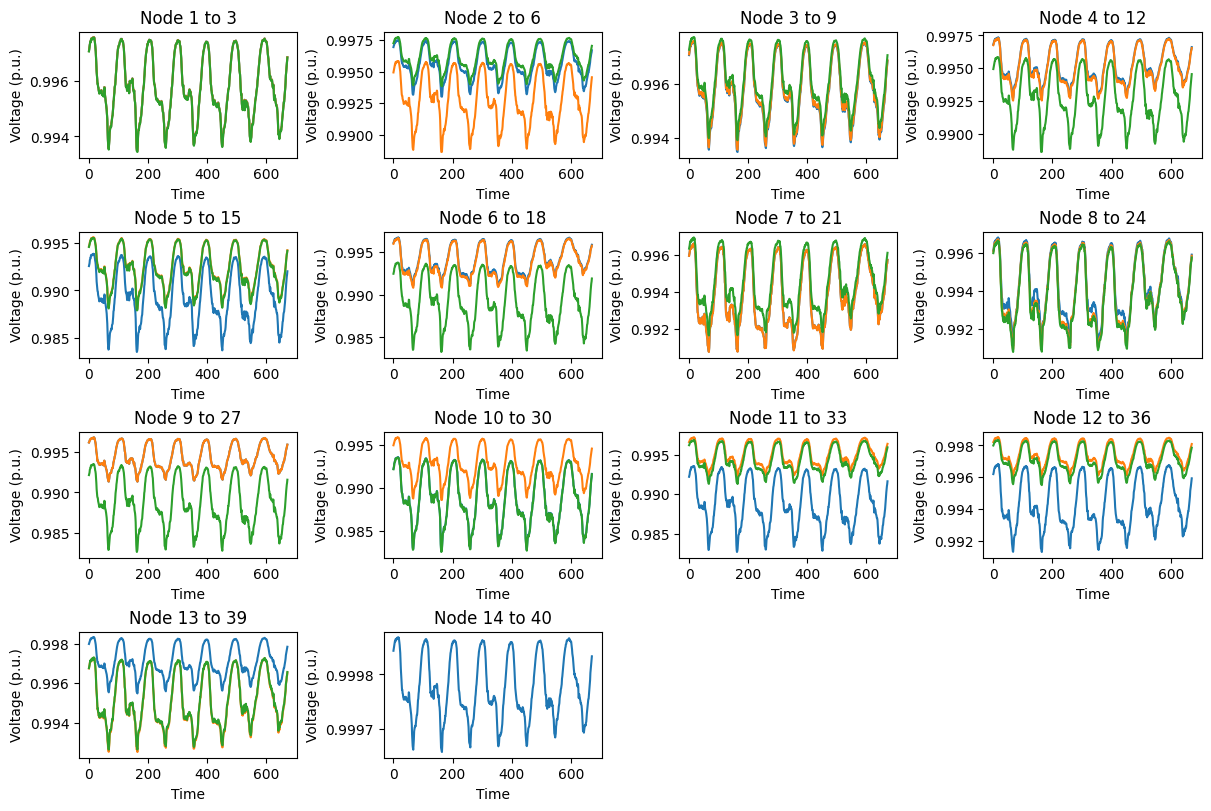

In [5]:
# plot u_pu of each node over time
# Create a figure with a 4x4 grid of subplots
# 3 ids per subplot
num_nodes = output_data[ComponentType.node].shape[1]
fig = plt.figure(figsize=(12, 8), layout="constrained")
gs = GridSpec(4, 4, figure=fig)
for cell_idx in range(0, num_nodes, math.ceil(num_nodes / 16)):
    ax = fig.add_subplot(gs[cell_idx // 12, cell_idx // 3 % 4])
    for node_idx in range(cell_idx, min(cell_idx + 3, num_nodes)):
        node_id = output_data[ComponentType.node]["id"][:,node_idx]
        u_pu = output_data[ComponentType.node]["u_pu"][:,node_idx]
        ax.plot(u_pu, label=node_id[0])
    ax.set_title(f"Node {cell_idx // 3 + 1} to {min(cell_idx + 3, num_nodes)}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Voltage (p.u.)")

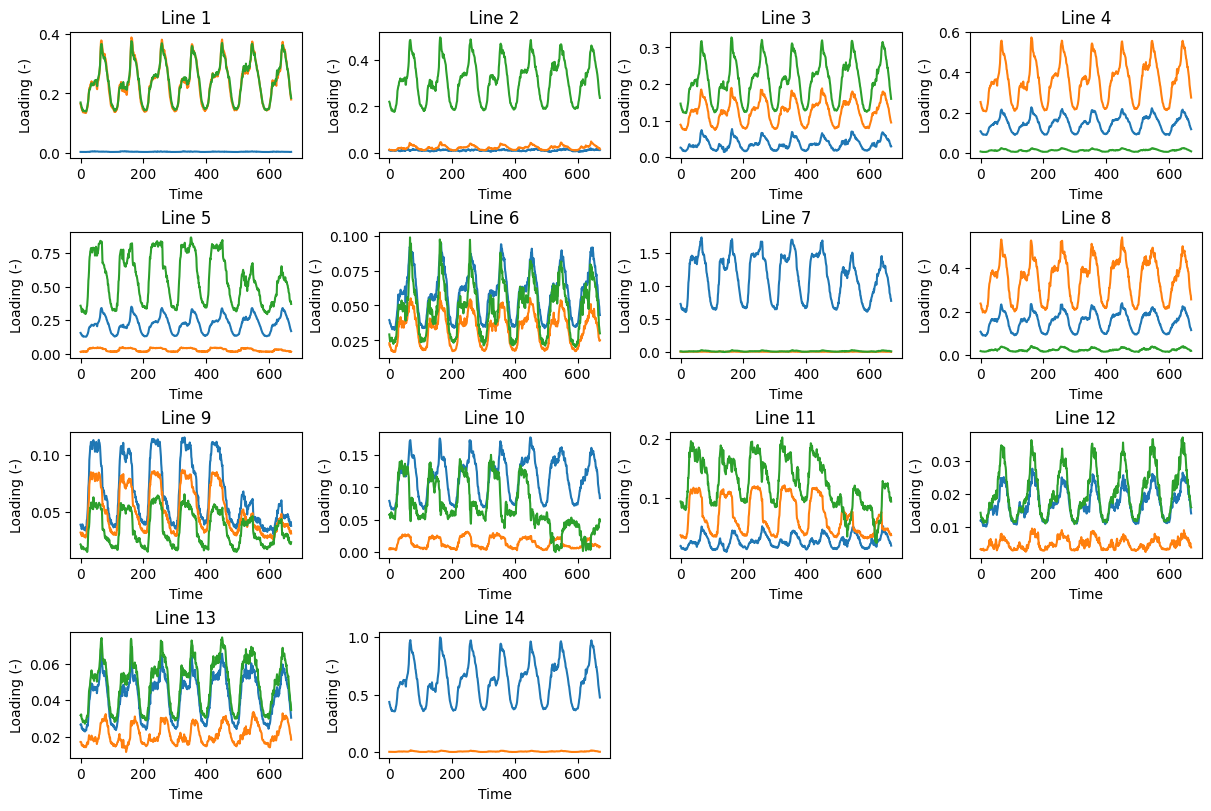

In [6]:
# plot loading of each line
# Create a figure with a 4x4 grid of subplots
# 41 lines, 3 ids per subplot
num_lines = output_data[ComponentType.line].shape[1]
fig = plt.figure(figsize=(12, 8), layout="constrained")
gs = GridSpec(4, 4, figure=fig)
for cell_idx in range(0, num_lines, math.ceil(num_lines / 16)):
    ax = fig.add_subplot(gs[cell_idx // 12, cell_idx // 3 % 4])
    for line_idx in range(cell_idx, min(cell_idx + 3, num_lines)):
        line_id = output_data[ComponentType.line]["id"][:,line_idx]
        loading = output_data[ComponentType.line]["loading"][:,line_idx]
        ax.plot(loading, label=line_id[0])
    ax.set_title(f"Line {cell_idx // 3 + 1}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Loading (-)")

## Visualize the Whole Graph

In [7]:
graph = nx.Graph()
graph.add_nodes_from(
    output_data[ComponentType.node]["id"][0],
)
graph.add_edges_from(
    zip(dataset[ComponentType.line]["from_node"], dataset[ComponentType.line]["to_node"]),
)
graph.add_edges_from(
    zip(dataset[ComponentType.transformer]["from_node"], dataset[ComponentType.transformer]["to_node"]),
)

pos=nx.spring_layout(graph, k=1.0, seed=43)

def visualize_snapshot(timestep: int) -> None:
    snapshot_node = output_data[ComponentType.node][timestep, :]  # shape (40,)
    snapshot_line = output_data[ComponentType.line][timestep, :]  # shape (#lines,)
    snapshot_transformer = output_data[ComponentType.transformer][0, :]  # shape (#transformers,)

    node_voltages = {_node["id"]: _node["u_pu"] for _node in snapshot_node}
    edge_loadings = {(_line_input["from_node"], _line_input["to_node"]): _line["loading"]
            for _line_input, _line in zip(dataset[ComponentType.line], snapshot_line)}
    edge_loadings.update({
        (_transformer_input["from_node"], _transformer_input["to_node"]): _transformer["loading"]
        for _transformer_input, _transformer in zip(dataset[ComponentType.transformer], snapshot_transformer)
    })
    for _node in snapshot_node:
        graph.nodes[_node["id"]]["voltage"] = _node["u_pu"]
    for _edge_from_to, _edge_loading in edge_loadings.items():
        graph.edges[_edge_from_to]["loading"] = _edge_loading

    fig, ax = plot_power_grid(
            graph,
            voltage_display='color',
            voltage_cmap="seismic",
            loading_display='color',
            loading_cmap="inferno_r",
            figsize=(10, 8),
            node_size=500,
            edge_width=3,
            font_size=10,
            loading_vmax=2,
            show_node_types=True,
            pos=pos,
        )

    plt.title('Power Grid Visualization')
    plt.show()

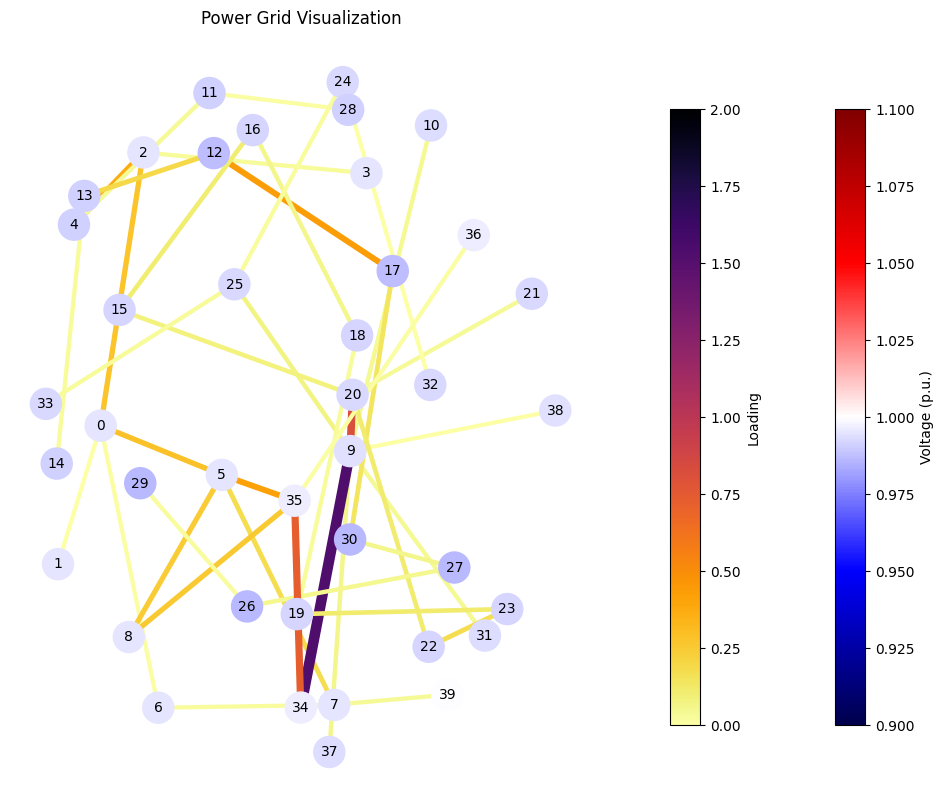

In [8]:
visualize_snapshot(timestep=250)

In [9]:
# use a slider
import ipywidgets as widgets
from ipywidgets import interact, interactive
from IPython.display import display

# Create a slider
slider = widgets.IntSlider(
    value=100,
    min=0,
    max=671,
    step=1,
    description='Timestep:',
    continuous_update=True,
)

interact(visualize_snapshot, timestep=slider)

interactive(children=(IntSlider(value=100, description='Timestep:', max=671), Output()), _dom_classes=('widget…

<function __main__.visualize_snapshot(timestep: int) -> None>